### Введение

In [6]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit

import shap
import ast  
import time
import random
import optuna


In [7]:
df_train = pd.read_json("../data/train.json")
df_test = pd.read_json("../data/test.json")

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [9]:
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Предварительная обработка

In [10]:
cols_to_keep_train = ['bathrooms', 'bedrooms', 'interest_level', 'created', 'price', 'features']
cols_to_keep_test  = ['bathrooms', 'bedrooms', 'features', 'created', 'price']

df_train = df_train[cols_to_keep_train].copy()
df_test  = df_test[cols_to_keep_test].copy()

df_train.head()

,bathrooms,bedrooms,interest_level,created,price,features
4,1.0,1,medium,2016-06-16 05:55:27,2400,"[Dining Room, Pre-War, Laundry in Building, Di..."
6,1.0,2,low,2016-06-01 05:44:33,3800,"[Doorman, Elevator, Laundry in Building, Dishw..."
9,1.0,2,medium,2016-06-14 15:19:59,3495,"[Doorman, Elevator, Laundry in Building, Laund..."
10,1.5,3,medium,2016-06-24 07:54:24,3000,[]
15,1.0,0,low,2016-06-28 03:50:23,2795,"[Doorman, Elevator, Fitness Center, Laundry in..."


In [11]:
q_low, q_high = df_train['price'].quantile([0.01, 0.99])

df_train = df_train[(df_train['price'] > q_low) & (df_train['price'] < q_high)]
df_test  = df_test[(df_test['price'] > q_low) & (df_test['price'] < q_high)]

In [12]:
empty_features_count = df_train['features'].apply(len).eq(0).sum()
print(f"Количество квартир с пустыми features: {empty_features_count}")

df_train = df_train[df_train['features'].apply(len) > 0].reset_index(drop=True)
df_train['features'] = df_train['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_test['features']  = df_test['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Количество квартир с пустыми features: 3106


In [13]:
df_train.loc[df_train['bathrooms'] > 4.0, 'bathrooms'] = df_train['bathrooms'].mean()
df_test.loc[df_test['bathrooms'] > 4.0, 'bathrooms'] = df_test['bathrooms'].mean() 

In [14]:
le = LabelEncoder()
df_train['interest_level_encoded'] = le.fit_transform(df_train['interest_level'])

In [15]:
for index, flat_features in enumerate(df_train['features']):
    list_features = {'Elevator', 'Hardwood Floors', 'Cats Allowed', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundryin Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace'}
    for feature in flat_features:
        if feature in list_features:
            df_train.loc[index, feature] = 1
            list_features.remove(feature)
            
    for feature in list_features:
        df_train.loc[index, feature] = 0
            

In [16]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'interest_level', 'created', 'price',
       'features', 'interest_level_encoded', 'Dining Room', 'Pre-War',
       'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed',
       'Cats Allowed', 'Swimming Pool', 'Terrace', 'Elevator',
       'Fitness Center', 'No Fee', 'Balcony', 'Outdoor Space', 'Roof Deck',
       'Laundryin Unit', 'Doorman', 'Laundry In Building', 'New Construction',
       'High Speed Internet'],
      dtype='object')

Text(0.5, 1.0, 'Гистограмма распределения цен на жильё')

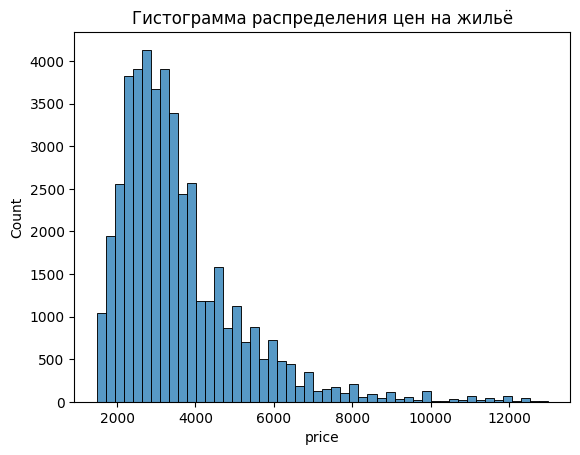

In [17]:
sns.histplot(data=df_train,
             x='price',
             bins=50)

plt.title('Гистограмма распределения цен на жильё')

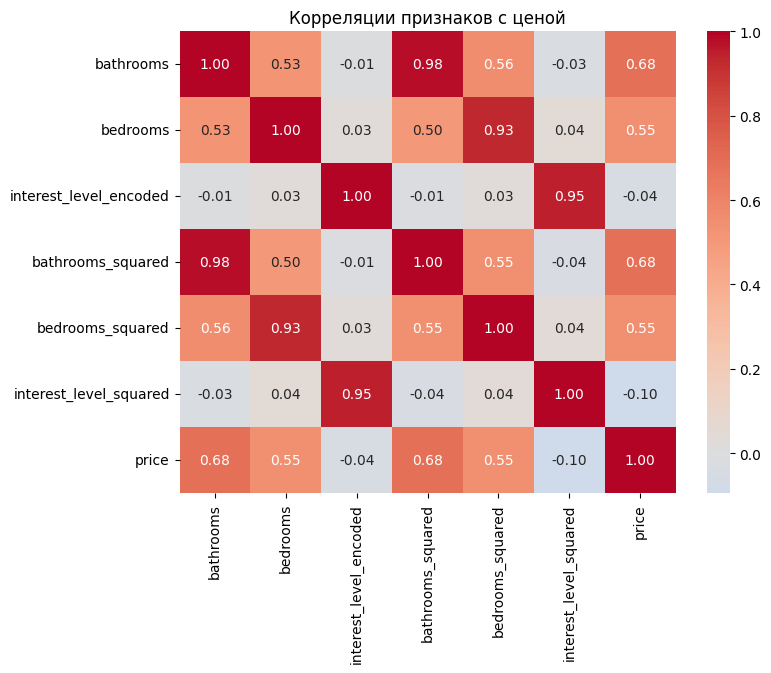

In [19]:
df_in_corr = df_train.copy()

df_in_corr['bathrooms_squared'] = df_in_corr['bathrooms'] ** 2
df_in_corr['bedrooms_squared'] = df_in_corr['bedrooms'] ** 2
df_in_corr['interest_level_squared'] = df_in_corr['interest_level_encoded'] ** 2

corr_matrix = df_in_corr[['bathrooms','bedrooms','interest_level_encoded',
                      'bathrooms_squared','bedrooms_squared','interest_level_squared',
                      'price']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции признаков с ценой")
plt.show()

In [20]:
df_train

,bathrooms,bedrooms,interest_level,created,price,features,interest_level_encoded,Dining Room,Pre-War,Laundry in Building,...,Fitness Center,No Fee,Balcony,Outdoor Space,Roof Deck,Laundryin Unit,Doorman,Laundry In Building,New Construction,High Speed Internet
0,1.0,1,medium,2016-06-16 05:55:27,2400,"[Dining Room, Pre-War, Laundry in Building, Di...",2,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,low,2016-06-01 05:44:33,3800,"[Doorman, Elevator, Laundry in Building, Dishw...",1,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,2,medium,2016-06-14 15:19:59,3495,"[Doorman, Elevator, Laundry in Building, Laund...",2,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0,low,2016-06-28 03:50:23,2795,"[Doorman, Elevator, Fitness Center, Laundry in...",1,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,3,low,2016-06-28 05:59:06,7200,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45232,1.0,3,low,2016-04-05 03:58:33,2800,"[Elevator, Dishwasher, Hardwood Floors]",1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45233,1.0,2,medium,2016-04-02 02:25:31,2395,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
45234,1.0,1,medium,2016-04-26 05:42:03,1850,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",2,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45235,1.0,2,medium,2016-04-19 02:47:33,4195,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",2,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = df_train.drop(columns=["interest_level", "price", "features"])
y = df_train['price']

### Методы разбиения данных 

In [ ]:
def random_split(X, y, test_size=0.2, random_state=None):
    n_samples = len(X)
    indices = np.arange(n_samples)
    # проверка на наличие random_state для воспроизводимости
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    # преобразование дробного размера тестовой выборки в абсолютное значение
    test_size_abs = int(n_samples * test_size)
    # распределение индексов для обучающей и тестовой выборок
    test_idx = indices[:test_size_abs]
    train_idx = indices[test_size_abs:]
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    return X_train, X_test, y_train, y_test

In [ ]:
def random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None):
    n_samples = len(X)
    if validation_size + test_size >= 1:
        raise ValueError("validation_size + test_size должен быть < 1")
    indices = np.arange(n_samples)
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    test_end = int(n_samples * test_size)
    val_end  = test_end + int(n_samples * validation_size)

    test_idx = indices[:test_end]
    val_idx  = indices[test_end:val_end]
    train_idx = indices[val_end:]

    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    X_test  = X.iloc[test_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    y_test  = y.iloc[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def date_split(X, y, date_column, date_split):
    X[date_column] = pd.to_datetime(X[date_column])
    train_mask = X[date_column] < date_split
    test_mask  = X[date_column] >= date_split
    X_train = X[train_mask]
    X_test  = X[test_mask]
    y_train = y[train_mask]
    y_test  = y[test_mask]
    return X_train, X_test, y_train, y_test

In [ ]:
print(df_train['created'].min())
print(df_train['created'].max())

In [ ]:
plt.figure(figsize=(10, 6))
df_train['created'] = pd.to_datetime(df_train['created'])
sns.histplot(data=df_train, x='created', bins=30, kde=False)
plt.ylabel('Количество объявлений')
plt.title('Распределение объявлений по датам создания') 
plt.show()

In [ ]:
def date_split_val(X, y, date_column, validation_date, test_date):
    X[date_column] = pd.to_datetime(X[date_column])
    val_mask = (X[date_column] >= validation_date) & (X[date_column] < test_date)
    test_mask = X[date_column] >= test_date
    train_mask = ~val_mask & ~test_mask      # ~ и & - это операторы для массивов
    X_train = X[train_mask]
    X_val = X[val_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_val = y[val_mask]
    y_test = y[test_mask]
    return X_train, X_val, X_test, y_train, y_val, y_test

### Методы перекрестной проверки:

In [ ]:
def k_fold(n_samples, k, shuffle=False, random_state=None):
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)

    fold_sizes = np.full(k, n_samples // k, dtype=int) # 
    fold_sizes[:n_samples % k] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start = current
        stop = current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate((indices[:start], indices[stop:])) 
        folds.append((train_indices, val_indices))
        current = stop
    return folds

Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.

В K-Fold разбиение происходит по отдельным объектам, поэтому связанные объекты могут попасть одновременно в train и validation, что приводит к утечке информации.

В Group K-Fold разбиение происходит по группам, и все объекты одной группы целиком попадают либо в train, либо в validation, что предотвращает утечку информации между выборками.

In [ ]:
def time_series(X, date_field, k):
    X_sorted = X.sort_values(by=date_field)
    indices = X_sorted.index.to_numpy()

    n_samples = len(indices)
    fold_size = n_samples // (k + 1)

    folds = []
    for i in range(k):
        train_end = fold_size * (i + 1)
        val_start = train_end
        val_end = val_start + fold_size

        train_idx = indices[:train_end]
        val_idx = indices[val_start:val_end]

        folds.append((train_idx, val_idx))

    return folds

### Сравнение всех методов проверки

In [ ]:
results = []

TARGET = 'interest_level_encoded'
DATE_COL = 'created'

feature_columns = X.columns.drop(DATE_COL)

def build_model_data(X, feature_columns):
    return X[feature_columns].copy()

#### random_split

In [ ]:
X_train, X_test, y_train, y_test = random_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### random_split_val

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split_val',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### date_split

In [ ]:
X_train, X_test, y_train, y_test = date_split(X, y, date_column='created', date_split='2016-06-01')

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start
    
results.append({
    'method': 'date_split',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae
})

#### date_split_val

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(X, y, date_column='created', validation_date='2016-05-20', test_date='2016-06-11')

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'date_split_val',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

results_df = pd.DataFrame(results)
print(results_df)

#### k_fold

In [ ]:
splits = k_fold(n_samples=len(X), k=5, shuffle=False, random_state=None)

for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val,model.predict(X_val_model))
    
    elapsed = time.perf_counter() - start

results.append({
    'method': 'k_fold',
    'metric': 'MAE',
    'val': np.mean(val_mae),
    'test': np.nan,
    'time_sec': elapsed
})

In [ ]:
splits

#### time_series

In [ ]:
splits = time_series(X, date_field='created', k=5)
val_mae_scores = []
for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    
    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
    val_mae_scores.append(val_mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'time_series',
    'metric': 'MAE',
    'val': np.mean(val_mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

#### Применяю соответствующие методы из библиотеки sklearn.

#### train_test_split (sklearn)

In [ ]:
X_model = X.drop(columns=['created'])
y_model = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split (sklearn)',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### train_test_split val (sklearn)

In [ ]:
# 1) отделяем test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2) отделяем val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  
    random_state=42,
    shuffle=True
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split val (sklearn)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### KFold (sklearn)

In [ ]:
kf = KFold(n_splits=5, shuffle=False)

mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_model)):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_model.iloc[train_idx]
    y_val   = y_model.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val))

    elapsed = time.perf_counter() - start

    mae_scores.append(val_mae)

results.append({
    'method': 'KFold (sklearn)',
    'metric': 'MAE',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

#### TimeSeriesSplit (sklearn)

In [ ]:
X_sorted = X.sort_values('created')
y_sorted = y.loc[X_sorted.index]

X_model = X_sorted.drop(columns=['created'])

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []

for train_idx, val_idx in tscv.split(X_model):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_sorted.iloc[train_idx]
    y_val   = y_sorted.iloc[val_idx]

    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train, y_train)
    mae = mean_absolute_error(y_val, model.predict(X_val))
    mae_scores.append(mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'TimeSeriesSplit (sklearn)',
    'metric': 'MAE',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

### Выбор функций

Построение модели регрессии Lasso с нормализованными признаками. Используйте мой метод разделения выборок на 3 части по полям, созданным в соотношении 60/20/20 — обучающая/валидационная/тестовая выборки.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

lasso = Lasso(alpha=0.1, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

y_val_pred = lasso.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso all features',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [ ]:
lasso_coefs = pd.Series(
    lasso.coef_,
    index=feature_columns
)

lasso_coefs_sorted = lasso_coefs.abs().sort_values(ascending=False)
lasso_coefs_sorted


In [ ]:
top_10_features = lasso_coefs_sorted.head(10).index.tolist()

X_train_top10 = X_train[top_10_features]
X_val_top10   = X_val[top_10_features]
X_test_top10  = X_test[top_10_features]
scaler_tonp10 = StandardScaler()

X_train_top10_scaled = scaler_tonp10.fit_transform(X_train_top10)
X_val_top10_scaled   = scaler_tonp10.transform(X_val_top10)
X_test_top10_scaled  = scaler_tonp10.transform(X_test_top10)

In [ ]:
lasso_top10 = Lasso(alpha=lasso.alpha, random_state=42, max_iter=10_000)

lasso_top10.fit(X_train_top10_scaled, y_train)

y_val_pred = lasso_top10.predict(X_val_top10_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso_top10.predict(X_test_top10_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso / top 10 features',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

Реализация метода для простого отбора признаков по соотношению NaN в признаках и корреляции.

In [ ]:
def simple_feature_selection(
    X: pd.DataFrame,
    y: pd.Series,
    nan_threshold: float = 0.3,
    top_k: int = 10
):
    nan_ratio = X.isna().mean()
    good_nan_features = nan_ratio[nan_ratio <= nan_threshold].index

    X_clean = X[good_nan_features]

    corr = X_clean.apply(lambda col: col.corr(y)) # считаем корреляцию каждого столбца признака с y (целевой переменной)
    corr_abs = corr.abs().sort_values(ascending=False)

    selected_features = corr_abs.head(top_k).index.tolist()

    return selected_features, corr_abs

In [ ]:
selected_features, corr_scores = simple_feature_selection(
    X_train,
    y_train,
    nan_threshold=0.3,
    top_k=10
)

Признаки отбирались на основе доли пропусков и абсолютного значения корреляции с целевой переменной. Из рассмотрения исключались признаки с долей пропусков выше порога, после чего выбирались top-K признаков с наибольшей линейной связью с целевой переменной.

In [ ]:
corr_scores

In [ ]:

top_corr = corr_scores.head(15)

plt.figure(figsize=(8, 5))
plt.barh(top_corr.index[::-1], top_corr.values[::-1])
plt.xlabel("Абсолютная корреляция с целевым показателем")
plt.title("Лучшие характеристики по абсолютной корреляции")
plt.tight_layout()
plt.show()

In [ ]:
X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]

scaler_fs = StandardScaler()
X_train_sel_scaled = scaler_fs.fit_transform(X_train_sel)
X_val_sel_scaled   = scaler_fs.transform(X_val_sel)
X_test_sel_scaled  = scaler_fs.transform(X_test_sel)

model_fs = Lasso(alpha=0.01, max_iter=10_000, random_state=42)
model_fs.fit(X_train_sel_scaled, y_train)

val_mae_fs = mean_absolute_error(
    y_val,
    model_fs.predict(X_val_sel_scaled)
)

test_mae_fs = mean_absolute_error(
    y_test,
    model_fs.predict(X_test_sel_scaled)
)

results.append({
    'method': 'Feature selection',
    'metric': 'MAE',
    'val': val_mae_fs,
    'test': test_mae_fs,
    'time_sec': np.nan
})

Метод перестановочной важности

In [ ]:
def permutation_importance(model, X_val, y_val, metric=mean_absolute_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = {}

    for col in X_val.columns:
        X_permuted = X_val.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col].values)

        permuted_score = metric(y_val, model.predict(X_permuted))
        importances[col] = permuted_score - baseline

    return importances

In [ ]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

perm_importance = permutation_importance(
    model,
    X_val_model,
    y_val
)

perm_df = (
    pd.Series(perm_importance)
      .sort_values(ascending=False)
)
feature_123 = perm_df.index.tolist()
top_10_features = perm_df.head(10).index.tolist()
print(top_10_features)

In [ ]:
feature_123

In [ ]:
X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'Permutation importance (top 10)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

Применение модели Shape

In [ ]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

explainer = shap.LinearExplainer(model,X_train_model)
shap_values = explainer.shap_values(X_val_model) # получаем матрицу SHAP значений для валидационного набора

shap_importance = (
    pd.DataFrame({
        'feature': X_val_model.columns,
        'importance': np.abs(shap_values).mean(axis=0)  # получаем средний абсолютный вклад признака в предсказание модели
    })
    .sort_values(by='importance', ascending=False) # Сортировка по важности
)

In [ ]:
print(shap_importance)

In [ ]:
top_10_features = shap_importance.head(10)['feature'].tolist()

X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'SHAP (top 10 features)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [ ]:
shap.summary_plot(
    shap_values,
    X_val_model,
    plot_type="bar"
)

SHAP-важность рассчитывается как средний абсолютный вклад признака в предсказание модели на валидационной выборке.

In [ ]:
df_results = pd.DataFrame(results)
print(df_results)   

### Оптимизация гиперпараметров

#### Запуск optuna на схеме Grid Search

Методы перебора по сетке и случайного поиска для параметров alpha и l1_ratio в модели ElasticNet из библиотеки sklearn.

In [ ]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf 
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

best_model = ElasticNet(
    **best_params, 
    random_state=42,
    max_iter=10_000
)
start = time.perf_counter()

best_model.fit(X_train_scaled, y_train)
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)
elapsed = time.perf_counter() - start
results.append({
    'method': 'ElasticNet Grid Search',
    'metric': 'MAE',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

#### Реализовываю методы Random Search

In [ ]:

alpha_range = np.logspace(-3, 1, 100)
l1_ratio_range = np.linspace(0.1, 0.9, 100)

n_iter = 30
best_mae = np.inf
best_params = None

for _ in range(n_iter):
    alpha = random.choice(alpha_range)
    l1_ratio = random.choice(l1_ratio_range)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        random_state=42,
        max_iter=10_000
    )

    start = time.perf_counter()
    model.fit(X_train_scaled, y_train)

    val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, val_pred)

    if val_mae < best_mae:
        best_mae = val_mae
        best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}


In [ ]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)
elapsed = time.perf_counter() - start
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

results.append({
    'method': 'ElasticNet Random Search',
    'metric': 'MAE',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [ ]:
df_results = pd.DataFrame(results)
print(df_results)

#### Наилучшее сочетание гиперпараметров модели

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {
                'alpha': alpha,
                'l1_ratio': l1_ratio
            }

In [ ]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)

test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

In [ ]:
print("Best params:", best_params)
print("Validation MAE:", best_mae)
print("Test MAE:", test_mae)

In [ ]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()

X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

In [ ]:
final_model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.7,
    max_iter=10_000,
    random_state=42
)
final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model with best params',
    'metric': 'MAE',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [ ]:
df_results = pd.DataFrame(results)
print(df_results)

In [ ]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)

#### Импорт Optuna и прровожу тот же эксперимент с ElasticNet

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10_000,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    return val_mae

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

final_model = ElasticNet(
    alpha=study.best_params['alpha'],
    l1_ratio=study.best_params['l1_ratio'],
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model (Optuna)',
    'metric': 'MAE',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [ ]:
df_results = pd.DataFrame(results)
print(df_results)

В рамках данного исследования были сравнены различные схемы валидации и подбора модели.
Несмотря на то, что случайные разбиения показали наилучшие значения MAE, они являются оптимистичными и потенциально нарушают временную структуру данных.
Наиболее корректным и устойчивым подходом оказался TimeSeriesSplit, как в реализации sklearn, так и в собственной реализации, демонстрируя сопоставимое качество при лучшей интерпретируемости и отсутствии утечек данных.
Методы отбора признаков и регуляризации (Lasso, ElasticNet, SHAP, permutation importance) не привели к улучшению качества, что указывает на распределённую информативность признаков.

#### Запуск optuna на одной из схем перекрестной проверки

In [ ]:
X_model = X.drop(columns=['created'])
y_model = y

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    mae_scores = []

    for train_idx, val_idx in tscv.split(X_model):
        X_train = X_model.iloc[train_idx]
        X_val   = X_model.iloc[val_idx]

        y_train = y_model.iloc[train_idx]
        y_val   = y_model.iloc[val_idx]

        # масштабирование ТОЛЬКО на train
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)

        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10_000,
            random_state=42
        )

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)

        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled  = scaler.transform(X_test_model)

In [ ]:
best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']

final_model = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1_ratio,
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

y_test_pred = final_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet (Optuna + TimeSeriesSplit)',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': np.nan
})

In [ ]:
df_results = pd.DataFrame(results)
df_results

Подбор гиперпараметров ElasticNet с использованием Optuna и временной перекрёстной проверки (TimeSeriesSplit) не привёл к значимому улучшению качества по сравнению с базовой линейной регрессией.
Это свидетельствует о том, что модель уже близка к оптимальной в рамках линейных зависимостей и текущего набора признаков.